<a href="https://colab.research.google.com/github/quinfer/football_managers/blob/master/football_manager.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# packages
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
data_path='/drive/MyDrive/football data/raw_dat/'

In [ ]:
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# Raw data on managers
club_manager_histories=pd.read_csv(data_path + 'club_manager_histories_df.csv')
match_dat=pd.read_csv(data_path + 'match_dat.csv')
spells=pd.read_csv(data_path + 'spells_df.csv')
manager_spells=pd.read_csv(data_path + 'manager_spells_df.csv')
# Raw data on matches
relative_strength=pd.read_csv(data_path + 'relative_strength_calc.csv')
relative_strength_club=pd.read_csv(data_path + 'relative_strength_calc_club_agg.csv')
# This is the final dataset created from old code
df_with_rsi=pd.read_csv(data_path + 'spells_with_rsi.csv')


<ipython-input-4-d02a0a438e0c>:3: DtypeWarning: Columns (12,45,48,56,58,59,60,61,66,72,95,99,109,129,167,175,180,198,202,203,204,206,211,222,248,249) have mixed types. Specify dtype option on import or set low_memory=False.
  match_dat=pd.read_csv(data_path + 'match_dat.csv')


# Raw Data
1. club managers histories

This is a a scrape of the histories from clubs which have been in the top two tiers of the professional football leagues in England, France, Italy, Spain, Germany, Turkey, Belgium, Greece, Turkey in the last 22 seasons up to 2022/2023. The scrape uses the staff profiles of each club then filters out only the manager histories.

2. Spells and manager_spells

Spells takes the staff_urls from the club manager histories and scrape the histories of each manager.  Spells includes all the roles the person has had in their career, whereas manager_spells is only the manager jobs.

3. match dat

This is the odds and results data for all leagues and season mentioned above from footballdata.co.uk

4. Index

Is a small file for matching transfermkt club names to the footballdata.co.uk club names.

5. Relative strength calculations

These are the following calculations:
$RS_{HomeTeamWin}=3-E_{points}(home) \\
RS_{Draw}=1-E_{points}() \\
RS_{AwayTeamWin}=3-E_{points}(home)
$


## Visualise Relative Strength
1. In the raw match data
2. For each event

In [ ]:
from tabulate import tabulate
sum_stats=relative_strength_club[['RS','Ex_pts']].describe().transpose()
print(tabulate(sum_stats, headers='keys', tablefmt='grid'))

+--------+---------+------------+----------+-------------+-----------+----------+----------+---------+
|        |   count |       mean |      std |         min |       25% |      50% |      75% |     max |
+========+=========+============+==========+=============+===========+==========+==========+=========+
| RS     |  327156 | 0.00528283 | 2.07793  | -2.99697    | -2.40694  | 0.410071 | 2.10422  | 2.99215 |
+--------+---------+------------+----------+-------------+-----------+----------+----------+---------+
| Ex_pts |  327156 | 0.60911    | 0.307846 |  0.00302681 |  0.376478 | 0.590866 | 0.815187 | 1.59926 |
+--------+---------+------------+----------+-------------+-----------+----------+----------+---------+


In [ ]:
sum_stats=df_with_rsi.describe().transpose()
print(tabulate(sum_stats, headers='keys', tablefmt='grid'))

+--------------------------+---------+--------------+-------------+----------------+-------------+---------------+-------------+-------------+
|                          |   count |         mean |         std |            min |         25% |           50% |         75% |         max |
+==========================+=========+==============+=============+================+=============+===============+=============+=============+
| RS                       |  695986 |  -0.0668069  |   2.10814   |    -2.99697    |  -2.47598   |   0.399347    |   2.12725   |    2.99215  |
+--------------------------+---------+--------------+-------------+----------------+-------------+---------------+-------------+-------------+
| Ex_pts                   |  695986 |   0.562305   |   0.295393  |     0.00302681 |   0.341086  |   0.539979    |   0.758543  |    1.59926  |
+--------------------------+---------+--------------+-------------+----------------+-------------+---------------+-------------+-------------+

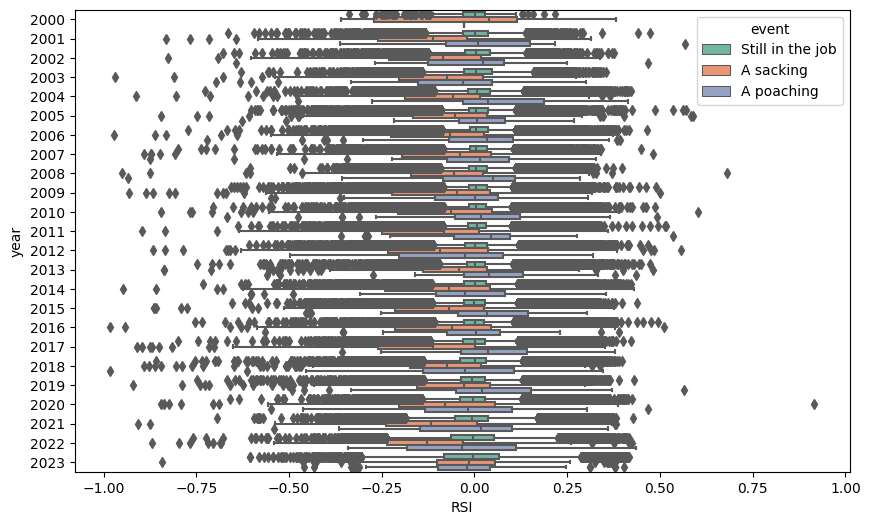

In [ ]:
# Extract the year from 'Date' column
df=df_with_rsi
df['year'] = pd.to_datetime(df['Date']).dt.year

# Convert 'year' to a string to treat it as a categorical variable
#df['year'] = df['year'].astype(str)

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='RSI', y='year', hue='event', palette="Set2", orient="h")

# Show the plot
plt.show()

In [ ]:
# Make sure to check the exact categories before reordering
print("Existing categories:", df['event'].astype('category').cat.categories)

Existing categories: Index(['A poaching', 'A sacking', 'Still in the job'], dtype='object')


In [ ]:
# Convert Date to year
df['year'] = pd.to_datetime(df['Date']).dt.year

# Convert to category type and reorder the categories
df['event'] = df['event'].astype('category')
df['event'].cat.reorder_categories(['Still in the job', 'A sacking', 'A poaching'], inplace=True)
df['event_code'] = df['event'].cat.codes  # Create a new column for the codes

# Produce a table to show the categories are encoded
category_mapping = pd.DataFrame({
    'event': df['event'].cat.categories,
    'event_code': range(len(df['event'].cat.categories))
})

# Count the number of occurrences for each event
event_counts = df['event'].value_counts().reset_index()
event_counts.columns = ['event', 'num_observations']

# Merge the count with the category_mapping DataFrame
category_mapping = pd.merge(category_mapping, event_counts, on='event', how='left')

print("\nMapping table between event and event code with number of observations:")
print(category_mapping)

# Convert 'year' to a string
df['year'] = df['year'].astype(str)

# Fit the multinomial logit model using the event_code column
formula = "event_code ~ RSI + WinRatio + RSI_ma + Onesideness"
#formula = "event_code ~ RSI"
model = smf.mnlogit(formula, data=df)
result = model.fit()

# Display results
print(result.summary())

<ipython-input-10-ddadaa235a60>:6: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df['event'].cat.reorder_categories(['Still in the job', 'A sacking', 'A poaching'], inplace=True)



Mapping table between event and event code with number of observations:
              event  event_code  num_observations
0  Still in the job           0            687339
1         A sacking           1              6108
2        A poaching           2              1301
Optimization terminated successfully.
         Current function value: 0.073959
         Iterations 9
                          MNLogit Regression Results                          
Dep. Variable:             event_code   No. Observations:               657718
Model:                        MNLogit   Df Residuals:                   657703
Method:                           MLE   Df Model:                           12
Date:                Tue, 05 Sep 2023   Pseudo R-squ.:                 0.05507
Time:                        07:07:27   Log-Likelihood:                -48644.
converged:                       True   LL-Null:                       -51479.
Covariance Type:            nonrobust   LLR p-value:                    

If we assume that the phenomenon of interest is indepenent across strata we can run a series of stratified multinominal logits.

Strata to consider:

1. Seasons

In [72]:
# Function to calculate season over all leagues
def determine_season(grouped_df):
    # Calculate days between games
    grouped_df['days_between'] = grouped_df['Date'].diff().dt.days

    # Set a threshold for days between games that indicates a new season.
    threshold = 60

    # Determine the season based on the threshold
    grouped_df['new_season_flag'] = (grouped_df['days_between'] > threshold) | grouped_df['days_between'].isnull()
    grouped_df['season_id'] = grouped_df['new_season_flag'].cumsum()

    # Label seasons based on the years they encompass
    grouped_df['season'] = grouped_df.apply(lambda row:
                                            f"{row['Date'].year-1}-{row['Date'].year}"
                                            if row['new_season_flag']
                                            else None, axis=1)
    grouped_df['season'].fillna(method='ffill', inplace=True)  # fill the None values with the previous season label

    # Drop helper columns
    grouped_df.drop(columns=['days_between', 'new_season_flag', 'season_id'], inplace=True)

    return grouped_df

# Group by 'league' and apply the function
df = df.groupby('Div').apply(determine_season).reset_index(drop=True)

<ipython-input-72-e81da9172f8b>:26: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('Div').apply(determine_season).reset_index(drop=True)


In [75]:
# Loop over each stratum, fit the model, and store the results
results = {}
formula = "event_code ~ RSI + WinRatio + RSI_ma + Onesideness"
for stratum, group in df.groupby('season'):

    model = smf.mnlogit(formula, data=group)
    result = model.fit()
    results[stratum] = result

# Now, results has the model results for each stratum
for stratum, result in results.items():
    print(f"Results for stratum {stratum}:")
    print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3025: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3026: RuntimeWarning: invalid value encountered in divide
  return eXB/eXB.sum(1)[:,None]


Optimization terminated successfully.
         Current function value: nan
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.079500
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.111464
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088453
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085360
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081728
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077814
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072837
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.062404
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.069726

In [ ]:
# Regular Logit

import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assuming df is your original DataFrame
# Filter the DataFrame to only include rows where event_code is 1 or 2
df_filtered = df[df['event_code'].isin([0, 1])]

# Fit the binary logistic regression model
formula = "event_code ~ RSI"
model = smf.logit(formula, data=df_filtered)
result = model.fit()

# Display the results
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.051211
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:             event_code   No. Observations:               564054
Model:                          Logit   Df Residuals:                   564052
Method:                           MLE   Df Model:                            1
Date:                Tue, 05 Sep 2023   Pseudo R-squ.:                 0.06234
Time:                        05:27:36   Log-Likelihood:                -28886.
converged:                       True   LL-Null:                       -30806.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.2714      0.035   -178.866      0.000      -6.340      -6.203
RSI            9.9341      0.

In [ ]:
!pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 12.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=1fb58d4963fadd0b68eaca3f797d497ac5477a0762f7e0aee74bb4e5175b2444
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
from lifelines import CoxPHFitter

# Fit the Cox Proportional Hazards model
cph = CoxPHFitter()
df_anal=df[['event','domestic_games_in_charge','RSI','WinRatio','Onesideness']]
cph.fit(df_anal, duration_col='domestic_games_in_charge', event_col='event',strata='')

# Display the model summary
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 459495 total observations, 458303 right-censored observations>
             duration col = 'domestic_games_in_charge'
                event col = 'poach'
      baseline estimation = breslow
   number of observations = 459495
number of events observed = 1192
   partial log-likelihood = -13566.01
         time fit was run = 2023-08-26 14:03:40 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
RSI          24.45   4.15e+10       0.58            23.31            25.59             1.33e+10             1.30e+11
WinRatio     -7.47       0.00       0.27            -8.00            -6.93                 0.00                 0.00
Onesideness   2.23       9.34       0.24             1.77             2.70                 5.87                14.87

              cmp to      z      p   -log2(p)
covariate                                    
RSI             0.00  42.01 <0.005        inf
WinRatio        0.00 -27.56 <0.005     552.96
Onesideness     0.00   9.43 <0.005      67.74
---
Concordance = 0.82
Partial AIC = 27138.02
log-likelihood ratio test = 2086.12 on 3 df
-log2(p) of ll-ratio test = inf

In [ ]:
from lifelines import CoxPHFitter

# Fit the Cox Proportional Hazards model
cph = CoxPHFitter()
df_anal=df[['sack','domestic_games_in_charge','RSI','WinRatio','Onesideness']]
cph.fit(df_anal, duration_col='domestic_games_in_charge', event_col='sack')

# Display the model summary
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 459495 total observations, 454256 right-censored observations>
             duration col = 'domestic_games_in_charge'
                event col = 'sack'
      baseline estimation = breslow
   number of observations = 459495
number of events observed = 5239
   partial log-likelihood = -61162.17
         time fit was run = 2023-08-26 14:04:38 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
RSI          15.91   8.11e+06       0.24            15.44            16.38             5.06e+06             1.30e+07
WinRatio    -10.24       0.00       0.13           -10.48            -9.99                 0.00                 0.00
Onesideness   1.50       4.47       0.12             1.27             1.72                 3.56                 5.61

              cmp to      z      p   -log2(p)
covariate                                    
RSI             0.00  66.17 <0.005        inf
WinRatio        0.00 -81.37 <0.005        inf
Onesideness     0.00  12.93 <0.005     124.56
---
Concordance = 0.83
Partial AIC = 122330.34
log-likelihood ratio test = 7143.44 on 3 df
-log2(p) of ll-ratio test = inf